# Imports

In [11]:
import yaml
from yaml import Loader
import networkx as nx

# Parse the YAML file

In [18]:
config = """name: GNNExample
dataset:
  name: test_dataset_2
  target_column: "exp"
  feature_columns:
    - smiles
featurizer:
  name: MolToGraphFeaturizer
  type: app.features.model.featurizers.MoleculeFeaturizer
  column_names:
    - smiles
  args:
    allow_unknown: false
    sym_bond_list: true
    per_atom_fragmentation: false
  column_names: ['smiles']
layers:
  - name: GCN1
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 30
      out_channels: 64
    input_layer: true # input_shape must match GINConv
    activation: relu
    input: MolToGraphFeaturizer
  - name: GCN2 
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 64
      out_channels: 64
    activation: relu
    input: GCN1
  - name: GCN3 # an arbitrary name 
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 64
      out_channels: 64
    activation: relu
    input: GCN2
  - name: GCN4
    type: torch_geometric.nn.GCNConv
    args:
      in_channels: 64
      out_channels: 64
    activation: ReLU
    input: GCN3
  - name: Pool4x1
    type: torch_geometric.nn.global_add_pool
    input: GCN4
  - name: Output
    type: torch.nn.Linear 
    args: 
      in_features: 64
      out_features: 1
    input: Pool4x1
    output_layer: true
"""

config = yaml.load(config, Loader=Loader)

# Setup the directed graph with `networkx`

In [26]:
net_graph = nx.DiGraph()

# Add the featurizer manually, since it's not in the layers object in the current config
## Moving to production, we should figure out the best way to link up the input values
## (either raw or through some featurizer/transform)
net_graph.add_node('MolToGraphFeaturizer')
print(net_graph)

DiGraph with 1 nodes and 0 edges


In [27]:
# First add all the other nodes
for layer in config['layers']:
    net_graph.add_node(layer['name'])

print(net_graph)

DiGraph with 7 nodes and 0 edges


In [28]:
# Then add all the edges
for layer in config['layers']:
    # Handle one input
    if isinstance(layer['input'], str):
        net_graph.add_edge(layer['input'], layer['name'])
    
    # Handle iterable of inputs
    else:
        for input_value in layer['input']:
            net_graph.add_edge(input_value, layer['name'])
            
print(net_graph)

DiGraph with 7 nodes and 6 edges


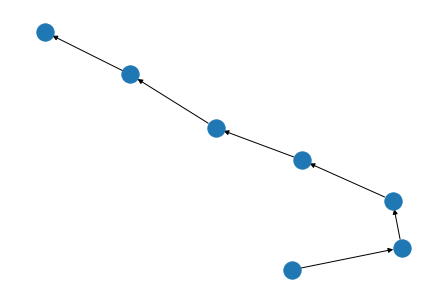

In [30]:
# We can print the graph
nx.draw(net_graph)

# Running checks

In [35]:
# Check to make sure the graph is connected (only one graph)
## Conversion to undirected view is required here.
## Do not convert to undirected, use a view.
assert nx.is_connected(net_graph.to_undirected(as_view=True))

# By using the view, the original graph should remain directed
net_graph.is_directed()

True

In [37]:
# We then need to verify that graph is directed acyclic
assert nx.is_directed_acyclic_graph(net_graph)

If both checks pass, we can retrieve a topoligical ordering that we can use to instantiate the network.

# Retrieving sorted nodes

To instantiate the network, we'll need a topological sort of the nodes in the graph. A topological sort oders the vertices of the directed graph ["such that for every directed edge uv from vertex u to vertex v, u comes before v in the ordering."](https://en.wikipedia.org/wiki/Topological_sorting)

In [38]:
list(nx.topological_sort(net_graph))

['MolToGraphFeaturizer', 'GCN1', 'GCN2', 'GCN3', 'GCN4', 'Pool4x1', 'Output']

In this case, the ordering is trivial, but that will not always be the case. Below is a branched example. I have omitted the unnecessary parts of the yaml file here for simplicity. 

In [45]:
config = """name: GNNExample2
layers:
  # Start the first branch
  - name: GCN1
  - name: GCN2 
    input: GCN1
  - name: GCN3 
    input: GCN2
  - name: GCN4
    input: GCN3
  - name: Pool
    input: GCN4

  # Start the second branch
  - name: Embedding
  - name: Linear1
    input: Embedding
  - name: Linear2
    input: Linear1

  # Handle the last layer
  - name: Concatenate
    input: [Pool, Linear2]
  - name: Output
    input: Concatenate
    output_layer: true
"""

In [46]:
def create_dag(yaml_config):
    """Function to generate the DAG and run checks"""
    
    # Load the yaml
    config = yaml.load(yaml_config, Loader=Loader)
    
    # Instantiate the graph
    net_graph = nx.DiGraph()
    
    # First add all the other nodes
    for layer in config['layers']:
        net_graph.add_node(layer['name'])
        
    # Then add all the edges
    for layer in config['layers']:
        
        if 'input' in layer:
        
            # Handle one input
            if isinstance(layer['input'], str):
                net_graph.add_edge(layer['input'], layer['name'])

            # Handle iterable of inputs
            else:
                for input_value in layer['input']:
                    net_graph.add_edge(input_value, layer['name'])

    print(f'Graph is connected: {nx.is_connected(net_graph.to_undirected(as_view=True))}')
    print(f'Graph is a DAG: {nx.is_directed_acyclic_graph(net_graph)}')
    
    nx.draw(net_graph)
    
    return net_graph

Graph is connected: True
Graph is a DAG: True


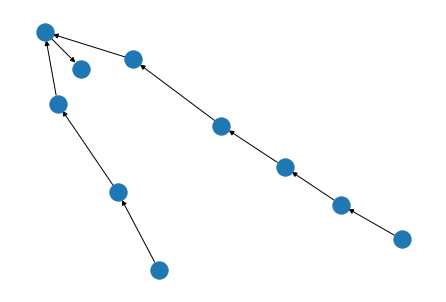

In [47]:
# The drawing is not a nice flowchart style diagram, but it does the job.
## Shows that the graph is connected and is, in fact a DAG.
net_config = create_dag(config)

# Network generation pseudocode

Below is a block of pseudocode to generate the network architecture and control flow from the DAG. In the code block below `forward

```
for node in nx.topological_sort(net_graph):

    # Add the layer type to the `__init__` function
    net.add_layer(type = node.type, name = node.name, args=node.args)
    
    # Add the appropriate step to the `forward` class method
    net.forward_pass.add(layer_name=node.name, args=node.input)
    
```

Obviously, this will take a lot of effort to implement, but using the graph traversal in this way will guarantee that we'll generate a valid DAG for the network.